In [1]:
import numpy as np
import os, time, sys
import simnibs
from simnibs import sim_struct, run_simnibs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy

def find_elements_composed_by_given_nodes(mesh, node_number):
    # mesh: origin .msh
    # node_number: roi node number (>0)
    node_coord = mesh.nodes.node_coord
    node_number_set = set(node_number)
    elm_node_number_list = mesh.elm.node_number_list[:, :3]
    elm_node_number_index = np.array([i for i in range(mesh.elm.nr) if len(node_number_set & set(elm_node_number_list[i])) == 3])
    crop_elm_number = mesh.elm.elm_number[elm_node_number_index]
    return crop_elm_number

# 1. Extract the Efield vectors within the ROI box area and save the result

In [2]:
m2m_folder  = r'H:\3Headmodel\snowp\m2m_ernie'  # ernie head model file path
sim_folder  = os.path.join(m2m_folder, '..\\tacs_2mA')
filename    = 'ernie_TDCS_1_scalar.msh'  # simulated results
head_mesh   = simnibs.read_msh(os.path.join(sim_folder,  filename))
gray_matter = head_mesh.crop_mesh(simnibs.ElementTags.GM) # Efield and mesh information of the gray matter
# gray_matter.view().show() # showing results in Gmsh software

In [3]:
'''Define the ROI box region'''
gm_roi  = simnibs.read_msh(os.path.join(m2m_folder, 'meshlab_file', 'pial_roi.msh'))
wm_roi  = simnibs.read_msh(os.path.join(m2m_folder, 'meshlab_file', 'white_roi.msh'))
ROIMesh = np.zeros((2, 3))
ROIMesh[0] = np.vstack((gm_roi.nodes.node_coord.min(axis=0), wm_roi.nodes.node_coord.min(axis=0))).min(axis=0)
ROIMesh[1] = np.vstack((gm_roi.nodes.node_coord.max(axis=0), wm_roi.nodes.node_coord.max(axis=0))).max(axis=0)
ROIMesh[0] = np.floor(ROIMesh[0])
ROIMesh[1] = np.ceil(ROIMesh[1])
print('ROI box region: ', ROIMesh[0], ROIMesh[1])

'''Extract the electric field information in the box area and display the result'''
elm_centers = gray_matter.elements_baricenters().value  # elment center
index_x   = np.logical_and(elm_centers.transpose()[0] >= ROIMesh[0, 0], elm_centers.transpose()[0] <= ROIMesh[1, 0])
index_y   = np.logical_and(elm_centers.transpose()[1] >= ROIMesh[0, 1], elm_centers.transpose()[1] <= ROIMesh[1, 1])
index_z   = np.logical_and(elm_centers.transpose()[2] >= ROIMesh[0, 2], elm_centers.transpose()[2] <= ROIMesh[1, 2])
index_roi = np.logical_and(index_x,  np.logical_and(index_y, index_z)) # np.logical_and is only applicable to the logical AND operation of two operands.
roi_elm_numbers = gray_matter.elm.elm_number[index_roi]            
roi_mesh = gray_matter.crop_mesh(elements=roi_elm_numbers)          
# roi_mesh.view().show()  # showing result in Gmsh
roi_max_connected_elm_index = np.argmax([len(item) for item in roi_mesh.elm.connected_components()]) 
roi_max_connected_elm_number = roi_mesh.elm.connected_components()[roi_max_connected_elm_index]     
roi_connected_mesh = roi_mesh.crop_mesh(elements=roi_max_connected_elm_number)                      
if False:
    roi_connected_mesh.view().show()

ROI box region:  [-63. -23.  28.] [-6. 32. 80.]


In [4]:
print([head_mesh.elmdata[i].field_name for i in range(len(head_mesh.elmdata))])
'''Save Efiled vectors within the expand ROI box'''
# Expand the above-mentioned box area outward by 2mm to ensure that all neurons are included.
expand_factor = 2 # mm
ROI_expand    = np.zeros_like(ROIMesh)
ROI_expand[0] = ROIMesh[0] - expand_factor
ROI_expand[1] = ROIMesh[1] + expand_factor
print('ROI expand box ranges：', ROI_expand[0], ROI_expand[1])

savePath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\ROIBox_Evector.npy' # save path
if not os.path.exists(savePath):
    '''Extract the electric field vector information of all nodes within the expand box area.'''
    nodedata_Evector = head_mesh.elmdata[0].elm_data2node_data()  # or   .as_nodedata()
    node_coords = head_mesh.nodes.node_coord
    index_x = np.logical_and(node_coords.transpose()[0] >= ROI_expand[0, 0], node_coords.transpose()[0] <= ROI_expand[1, 0])
    index_y = np.logical_and(node_coords.transpose()[1] >= ROI_expand[0, 1], node_coords.transpose()[1] <= ROI_expand[1, 1])
    index_z = np.logical_and(node_coords.transpose()[2] >= ROI_expand[0, 2], node_coords.transpose()[2] <= ROI_expand[1, 2])
    node_index_in_expand_box = np.logical_and(index_x,  np.logical_and(index_y, index_z))
    Efield_position_node = node_coords[node_index_in_expand_box, :]
    Efield_vector_node   = nodedata_Evector[node_index_in_expand_box, :]
    
    '''Extract the electric field vector information of the center of all elements within the expand box area.'''
    elm_centers = head_mesh.elements_baricenters().value  # 计算四面体元素的重心
    index_x = np.logical_and(elm_centers.transpose()[0] >= ROI_expand[0, 0], elm_centers.transpose()[0] <= ROI_expand[1, 0])
    index_y = np.logical_and(elm_centers.transpose()[1] >= ROI_expand[0, 1], elm_centers.transpose()[1] <= ROI_expand[1, 1])
    index_z = np.logical_and(elm_centers.transpose()[2] >= ROI_expand[0, 2], elm_centers.transpose()[2] <= ROI_expand[1, 2])
    index_expand_box = np.logical_and(index_x,  np.logical_and(index_y, index_z))
    elm_index_in_expand_box = head_mesh.elm.elm_number[index_expand_box] - 1
    Efield_position_elm = elm_centers[elm_index_in_expand_box, :]
    Efield_vector_elm   = head_mesh.elmdata[0].value[elm_index_in_expand_box, :]
    
    '''Save the electric field vector information of the expand box area'''
    data = {
        'cube_range': ROI_expand,
        'E_position_elm': Efield_position_elm,
        'E_vector_elm': Efield_vector_elm,
        'E_position_node': Efield_position_node,
        'E_vector_node': Efield_vector_node,
    }
    np.save(savePath, data)

['E', 'magnE', 'J', 'magnJ']
ROI expand box ranges： [-65. -25.  26.] [-4. 34. 82.]


# 2. Draw the surface of the central gray matter and the distribution of electric fields in the ROI area

In [4]:
sim_folder = r'H:\3Headmodel\snowp\tacs_2mA'
mid_gm_surf = simnibs.read_msh(os.path.join(sim_folder, 'subject_overlays', 'ernie_TDCS_1_scalar_central.msh'))
# mid_gm_surf.view().show()

In [5]:
atlas = simnibs.subject_atlas('a2009s', r'H:\3Headmodel\snowp\m2m_ernie')
region_name = ['lh.G_postcentral', 'lh.S_central', 'lh.G_precentral']
roi = atlas[region_name[0]] + atlas[region_name[1]] + atlas[region_name[2]]
roi_bool = roi.astype(bool)
roi_elm_number = find_elements_composed_by_given_nodes(mid_gm_surf, mid_gm_surf.nodes.node_number[roi_bool])
mid_gm_surf_roi = mid_gm_surf.crop_mesh(elements=roi_elm_number)
# mid_gm_surf_roi.view().show()

# 3. Interpolated electric field information of the surface where Layer 5 soma is located (or other layer surface)

In [22]:
from simnibs.utils.mesh_element_properties import ElementTags
from simnibs.utils.simnibs_logger import logger
from simnibs.utils.file_finder import templates, SubjectFiles, get_reference_surf
from simnibs.utils.csv_reader import write_csv_positions, read_csv_positions
def interpolation_to_given_surface(
    mesh_fn,
    m2m_folder,
    out_folder,
    depth=0.5,
    interp_surf_name='central',
    quantities=["magn", "normal", "tangent", "angle"],
    fields=None,
    open_in_gmsh=False,
    f_geo=None
):
    """Interpolates the vector fieds in the middle gray matter surface

    Parameters
    -----------
    mesh_fn: str
        String with file name to mesh
    m2m_folder: str
        Path to the m2m_{subject_id} folder, generated during the segmantation
    out_folder: str
        Name of output folder. Output files will be written to this folder
    depth: float (optional)
        The distance bewteen grey and white matter where the
        interpolation should be done. p = depth * wm + (1 - depth) * gm (default: .5)
    quantities: list with the elements {magn, normal, tangent, angle}
        Quantites to be calculated from vector field
    fields: list of strings (optional)
        Fields to be transformed. Default: all fields
    open_in_gmsh: bool
        If true, opens a Gmsh window with the interpolated fields
    f_geo: str
        String with file name to geo file that accompanies the mesh
    """
    from simnibs.mesh_tools import mesh_io

    m2m_folder = os.path.abspath(os.path.normpath(m2m_folder))
    subject_files = SubjectFiles(subpath=m2m_folder)
    if depth < 0.0 or depth > 1.0:
        raise ValueError("Invalid depth value. Should be between 0 and 1")

    if any([q not in ["magn", "normal", "tangent", "angle"] for q in quantities]):
        raise ValueError("Invalid quanty in {0}".format(quantities))

    def calc_quantities(nd, quantities):
        d = dict.fromkeys(quantities)
        for q in quantities:
            if q == "magn":
                d[q] = nd.norm()
            elif q == "normal":
                d[q] = nd.normal()
                d[q].value *= -1
            elif q == "tangent":
                d[q] = nd.tangent()
            elif q == "angle":
                d[q] = nd.angle()
            else:
                raise ValueError("Invalid quantity: {0}".format(q))
        return d

    m = mesh_io.read_msh(mesh_fn)
    _, sim_name = os.path.split(mesh_fn)
    sim_name = "." + os.path.splitext(sim_name)[0]

    # Crop out WM, GM, and CSF. We add WM and CSF to make the mesh convex.
    m = m.crop_mesh(tags=[ElementTags.WM, ElementTags.GM, ElementTags.CSF])

    # Set the volume to be GM. The interpolation will use only the tetrahedra in the volume.
    th_indices = m.elm.elm_number[m.elm.tag1 == ElementTags.GM]

    if not os.path.isdir(out_folder):
        os.mkdir(out_folder)
    out_folder = os.path.abspath(os.path.normpath(out_folder))

    names_subj = []


    middle_surf = mesh_io.load_subject_surfaces(subject_files, interp_surf_name)


    for hemi in subject_files.hemispheres:
        mesh_io.write_freesurfer_surface(
            middle_surf[hemi],
            os.path.join(out_folder, hemi + ".%s" % interp_surf_name)
        )

    h = []
    for name, data in m.field.items():
        for hemi in subject_files.hemispheres:
            if fields is None or name in fields:
                # Interpolate to middle gm
                interpolated = data.interpolate_to_surface(
                    middle_surf[hemi], th_indices=th_indices
                )

                # For vector quantities, calculate quantities (normal, magn, ...)
                if data.nr_comp == 3:
                    q = calc_quantities(interpolated, quantities)
                    for q_name, q_data in q.items():
                        out_subj = os.path.join(
                            out_folder,
                            hemi + sim_name + ".%s." % interp_surf_name + name + "." + q_name,
                        )
                        mesh_io.write_curv(
                            out_subj, q_data.value, middle_surf[hemi].elm.nr
                        )
                        names_subj.append(out_subj)
                        middle_surf[hemi].add_node_field(q_data, f"{name}_{q_name}")
                        h.append(hemi)
                        
                elif data.nr_comp == 1:
                    field_name = name[-1]
                    q_name = name[:-1]
                    if field_name in m.field.keys() and q_name in quantities:
                        # If we have an equivalent quantity being calculated, skip
                        pass
                    else:
                        out_subj = os.path.join(
                            out_folder, hemi + sim_name + ".%s." % interp_surf_name + name
                        )
                        mesh_io.write_curv(
                            out_subj,
                            interpolated.value.squeeze(),
                            middle_surf[hemi].elm.nr,
                        )
                        names_subj.append(out_subj)
                        h.append(hemi)
                        middle_surf[hemi].add_node_field(interpolated, name)

    # Join surfaces, fields and open in gmsh
    # I only work with lh and rh at least for now
    # It also needs to be nicely ordered, otherwise will
    # screw up the atlases

    def join_and_write(surfs, fn_out, open_in_gmsh, f_geo=None):
        mesh = surfs["lh"].join_mesh(surfs["rh"])
        mesh.elm.tag1 = ElementTags.GM_TH_SURFACE * np.ones(mesh.elm.nr, dtype=int)
        mesh.elm.tag2 = ElementTags.GM_TH_SURFACE * np.ones(mesh.elm.nr, dtype=int)
        mesh.nodedata = []
        mesh.elmdata = []
        for k in surfs["lh"].field.keys():
            mesh.add_node_field(
                np.append(surfs["lh"].field[k].value, surfs["rh"].field[k].value), k
            )
        mesh_io.write_msh(mesh, fn_out)

        # write .opt-file
        v = mesh.view(visible_fields=list(surfs["lh"].field.keys())[0])
        if f_geo is not None:
            if not os.path.exists(f_geo):
                raise FileNotFoundError(f"Could not find file: {f_geo}")
            v.add_merge(f_geo, append_views_from_geo=True)
        v.write_opt(fn_out)

        if open_in_gmsh:
            mesh_io.open_in_gmsh(fn_out, True)

    join_and_write(
        middle_surf,
        os.path.join(out_folder, sim_name[1:] + "_%s.msh" % interp_surf_name),
        open_in_gmsh,
        f_geo,
    )

In [23]:
mesh_fn    = r'H:\3Headmodel\snowp\tacs_2mA\ernie_TDCS_1_scalar.msh'
m2m_folder = r'H:\3Headmodel\snowp\m2m_ernie'
out_folder = r'H:\3Headmodel\snowp\tacs_2mA\subject_overlays'
interp_surf_name = 'Layer5'
f_geo = r'H:\3Headmodel\snowp\tacs_2mA\ernie_TDCS_1_el_currents.geo'
if not os.path.exists(os.path.join(out_folder, 'ernie_TDCS_1_scalar_%s.msh' % interp_surf_name)):
    interpolation_to_given_surface(mesh_fn, m2m_folder, out_folder, interp_surf_name=interp_surf_name, open_in_gmsh=True, f_geo=f_geo)

# 4. Draw the surface electric field distribution of the soma in the L5 layer and the electric field distribution in the ROI area

In [5]:
sim_folder = r'H:\3Headmodel\snowp\tacs_2mA'
L5_surf = simnibs.read_msh(os.path.join(sim_folder, 'subject_overlays', 'ernie_TDCS_1_scalar_Layer5.msh'))
# L5_surf.view().show()
atlas = simnibs.subject_atlas('a2009s', r'H:\3Headmodel\snowp\m2m_ernie')
region_name = ['lh.G_postcentral', 'lh.S_central', 'lh.G_precentral']
roi = atlas[region_name[0]] + atlas[region_name[1]] + atlas[region_name[2]]
roi_bool = roi.astype(bool)
roi_elm_number = find_elements_composed_by_given_nodes(L5_surf, L5_surf.nodes.node_number[roi_bool])
L5_surf_roi = L5_surf.crop_mesh(elements=roi_elm_number)
print('L5 ROI Surf faces number is: %d' % L5_surf_roi.elm.nr)
print('L5 ROI Surf vertices number is: %d' % L5_surf_roi.nodes.nr)
# L5_surf_roi.view().show()

L5 ROI Surf faces number is: 16196
L5 ROI Surf vertices number is: 8336


['E_magn', 'E_normal', 'E_tangent', 'E_angle', 'J_magn', 'J_normal', 'J_tangent', 'J_angle']


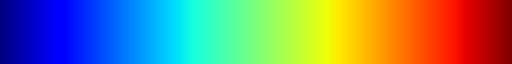

In [6]:
print([L5_surf_roi.nodedata[i].field_name for i in range(len(L5_surf_roi.nodedata))])
elm_Emag_data = L5_surf_roi.nodedata[0].node_data2elm_data().value
vertices = L5_surf_roi.nodes.node_coord
faces = L5_surf_roi.elm.node_number_list[:, :3] - 1
sorted_indices = np.argsort(elm_Emag_data)

value_min, value_max = 0, 0.455
color_numPoint = 5000
value_array    = np.linspace(value_min, value_max, color_numPoint)
list_color0    = plt.get_cmap('jet', lut=color_numPoint) # .reversed()
# list_color     = [list_color0(i) for i in range(color_numPoint)]
list_color = []
for i in range(elm_Emag_data.shape[0]):
    if elm_Emag_data[i] >= value_max:
        list_color.append(list_color0(-1))
    elif elm_Emag_data[i] <= value_min:
        list_color.append(list_color0(0))
    else:    
        diff = np.abs(value_array - elm_Emag_data[i])
        closest_indices = np.argmin(diff)
        list_color.append(list_color0(closest_indices))
list_color0

(-66.87555079989963,
 0.14079909854465456,
 -29.037187629275856,
 37.979162269168434,
 27.986993749936417,
 78.24925617376964)

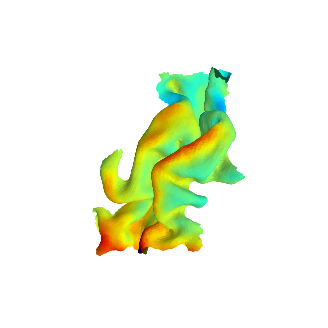

In [21]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
fig, ax = plt.subplots(1, 1, figsize=(4, 4), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices[face] for face in faces], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')